# Adult Income Dataset - Data Quality Evaluation

**Dataset:** UCI Adult Income Dataset  
**Source:** https://archive.ics.uci.edu/dataset/2/adult

## Overview

This notebook tests how well we can recover from heavily corrupted data on the Adult dataset. We take clean baseline data, inject multiple corruption types simultaneously (missing values, noise, categorical shifts, label swaps, etc.), then compare two cleaning strategies.

The evaluation tracks performance through four stages:
1. **Baseline** - Clean data performance
2. **Corrupted** - After injecting all corruptions
3. **Cleaned (Traditional)** - Using rule-based fixes (imputation, salvage, AutoClean)
4. **Cleaned (Model-Aware)** - Traditional cleaning + Cleanlab for mislabeled data detection

## Models Tested
- Logistic Regression
- Histogram Gradient Boosting Classifier

## Environment
- Platform: Google Colab
- Runtime: Python 3.11 (Note: You can use the newer versions of Python as well. Except for the tensorflow towards the end of the notebook block which requires 3.11)
- Storage: Google Drive for data persistence

## Setup and Dependencies

Installing required libraries for data corruption (Jenga), cleaning (AutoClean, Cleanlab), and modeling (scikit-learn).

In [1]:
# Install all required packages
!pip install -q datasets scikit-learn pandas numpy setuptools matplotlib
!pip install -q py-AutoClean cleanlab jenga ftfy ucimlrepo category_encoders

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.1/306.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.9 MB/s eta 0:00:00


## Environment Setup

This notebook can run in three environments:
- **Google Colab** - Mounts Google Drive for persistent storage
- **Local/Jupyter** - Uses current working directory
- **GitHub Codespaces** - Works from repo root

The cell below detects the environment and sets up paths accordingly.

In [3]:
import os
import sys

# Detect environment
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

# Setup paths based on environment
if IN_COLAB:
    # Mount Google Drive
    drive.mount('/content/drive')
    WORK_DIR = '/content/drive/MyDrive/adults-dataset-categorical-numerical'
    os.makedirs(WORK_DIR, exist_ok=True)
    os.chdir(WORK_DIR)
    print(f"Running in Google Colab")
    print(f"Working directory: {WORK_DIR}")
else:
    # Local or GitHub - use current directory or repo root
    WORK_DIR = os.getcwd()
    print(f"Running locally")
    print(f"Working directory: {WORK_DIR}")

# Create folder structure (if not exists)
folders = [
    'data/baseline',
    'data/corrupted',
    'data/cleaned',
    'results/figures',
    'results/statistical_tests',
    'results/tfdv_analysis',
    'python_scripts',
    'notebook'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folder structure ready")
print("=" * 50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running in Google Colab
Working directory: /content/drive/MyDrive/adults-dataset-categorical-numerical
Folder structure ready


## Import Libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import ttest_rel, ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries loaded")

Libraries loaded


## Results Logger

We use a custom logger to track model performance across different stages (baseline, corrupted, cleaned). This writes results to a CSV file for later analysis and visualization.

In [4]:
import pandas as pd
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

class ResultsLogger:
    """
    Helper class to log experiment results to a combined CSV file.
    Call this after each corruption/cleaning step to record metrics.
    """

    def __init__(self, results_path):
        self.results_path = results_path
        os.makedirs(os.path.dirname(results_path), exist_ok=True)

        # Initialize CSV with headers if it doesn't exist
        if not os.path.exists(results_path):
            df_init = pd.DataFrame(columns=[
                'model', 'experiment', 'cleaning_level', 'cleaning_name',
                'accuracy', 'precision', 'recall', 'f1',
                'n_samples_before', 'n_samples_after', 'rows_dropped',
                'cleaning_time', 'eval_time'
            ])
            df_init.to_csv(results_path, index=False)
            print(f"Initialized results file: {results_path}")

    def log_result(self, model_name, experiment_name, cleaning_level, cleaning_name,
                   y_true, y_pred, n_before, n_after, cleaning_time=0, eval_time=0):
        """
        Log a single experiment result.

        Args:
            model_name: str, e.g., "LogisticRegression" or "HistGradientBoosting"
            experiment_name: str, e.g., "all_corruptions"
            cleaning_level: int, 0=baseline, 1=corrupted, 2=cleaned_no_cleanlab, 3=cleaned_cleanlab
            cleaning_name: str, e.g., "0_Baseline", "1_Corrupted", "2_Cleaned_NoCleanlab"
            y_true: array-like, true labels
            y_pred: array-like, predicted labels
            n_before: int, number of samples before this step
            n_after: int, number of samples after this step
            cleaning_time: float, time spent cleaning (seconds)
            eval_time: float, time spent evaluating (seconds)
        """

        # Calculate metrics
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        rows_dropped = n_before - n_after

        # Create result row
        result = {
            'model': model_name,
            'experiment': experiment_name,
            'cleaning_level': cleaning_level,
            'cleaning_name': cleaning_name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'n_samples_before': n_before,
            'n_samples_after': n_after,
            'rows_dropped': rows_dropped,
            'cleaning_time': cleaning_time,
            'eval_time': eval_time
        }

        # Append to CSV
        df_result = pd.DataFrame([result])
        df_result.to_csv(self.results_path, mode='a', header=False, index=False)

        print(f"Logged: {model_name} | {cleaning_name} | Acc={acc:.4f} | F1={f1:.4f}")

        return result

## Load Dataset

We use a preprocessed version of the Adult dataset stored in the repo. The original dataset is available at: https://archive.ics.uci.edu/dataset/2/adult

The preprocessing steps applied:
- Selected relevant features (age, workclass, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, income)
- Saved as `adult_for_manual_edit.csv` in `data/baseline/`

In [5]:
import os
import pandas as pd

# Use relative path from WORK_DIR
adult_path = os.path.join(WORK_DIR, 'data/baseline/adult_for_manual_edit.csv')

# Verify file exists
if not os.path.exists(adult_path):
    raise FileNotFoundError(f"Dataset not found at: {adult_path}\nPlease ensure the data file is in data/baseline/")

print(f"Dataset found: {adult_path}")
print(f"File size: {os.path.getsize(adult_path) / (1024*1024):.2f} MB")

Dataset found: /content/drive/MyDrive/adults-dataset-categorical-numerical/data/baseline/adult_for_manual_edit.csv
File size: 3.65 MB


## Data Inspection

Quick check of the dataset structure and quality before we start the evaluation.

In [6]:
# Load dataset
adult_df = pd.read_csv(adult_path)

print(f"Total rows: {len(adult_df):,}")
print(f"Total columns: {len(adult_df.columns)}")
print(f"\nColumns: {list(adult_df.columns)}")
print(f"\nData types:\n{adult_df.dtypes}")
print(f"\nMissing values per column:\n{adult_df.isnull().sum()}")

# Preview first few rows
adult_df.head()

Total rows: 48,842
Total columns: 12

Columns: ['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']

Data types:
age                object
workclass          object
education-num      object
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain       object
capital-loss      float64
hours-per-week    float64
income             object
dtype: object

Missing values per column:
age                 0
workclass         963
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
income              0
dtype: int64


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,39.0,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.5,0.0,40.0,<=50K
1,50n,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,-1.0,0.0,13.0,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,?,0.0,40.0,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0.0,40.8,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0.2,40.0,<=50K


## Numeric Features Summary

The dataset contains 5 numeric features that we'll track throughout the corruption and cleaning process.

In [7]:
numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

print("Numeric features summary:")
adult_df[numeric_features].describe()

Numeric features summary:


,capital-loss,hours-per-week
count,48842.000000,48842.000000
mean,87.502318,40.422399
std,403.004551,12.391444
min,0.000000,1.000000
25%,0.000000,40.000000
50%,0.000000,40.000000
75%,0.000000,45.000000
max,4356.000000,99.000000


## Data Preprocessing

The Adult dataset is imbalanced (more people earn <=50K than >50K). We balance it by downsampling both classes to 10,000 samples each, giving us 20,000 total samples for evaluation.

We also define the preprocessing pipeline:
- **Numeric features:** Standardized using StandardScaler
- **Categorical features:** One-hot encoded

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from AutoClean import AutoClean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import resample

df = pd.read_csv(adult_path)

numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

def resample_df(df):
    target_column = df.columns[-1]
    X = df.drop(columns=[target_column]).copy()
    y = df[[target_column]].copy()

    train = X.copy()
    train['income'] = y

    class_1 = train[train['income'] == '<=50K']
    class_2 = train[train['income'] == '>50K']

    class_1_resampled = resample(class_1,
                                replace=False,
                                n_samples=10000,
                                random_state=42)

    class_2_resampled = resample(class_2,
                                replace=False,
                                n_samples=10000,
                                random_state=42)

    df_balanced = pd.concat([class_1_resampled, class_2_resampled]).sample(frac=1, random_state=42)
    X = df_balanced.drop(columns=['income'])
    y = df_balanced['income']

    return X, y

X, y = resample_df(df)

categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

## Model 1: Logistic Regression

We test the full pipeline on Logistic Regression:
1. **Baseline** - Train on clean balanced data
2. **Corrupted** - Apply numerical corruptions, then categorical corruptions (shift, typos, missing values)
3. **Cleaned (Traditional)** - Use salvage functions, imputation, and AutoClean
4. **Cleaned (Model-Aware)** - Same as above + Cleanlab to remove suspect labels

Results are logged at each stage for comparison.

In [9]:
import sys
sys.path.append(os.path.join(WORK_DIR, 'python_scripts'))
import inject
import clean_num
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Initialize logger
logger = ResultsLogger(os.path.join(WORK_DIR, 'results/ALL_RESULTS_ADULT_COMBINED.csv'))

numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

# Create Logistic Regression pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        class_weight='balanced'
    ))
])

# BASELINE
X_baseline = X.copy()
for col in numeric_features:
    X_baseline[col] = pd.to_numeric(X_baseline[col], errors='coerce')  # Convert but DON'T fill yet

# Split FIRST
X_train, X_test, y_train, y_test = train_test_split(X_baseline, y, test_size=0.3, random_state=42)

# Fill AFTER split
X_train_filled = X_train.copy()
X_test_filled = X_test.copy()
for col in numeric_features:
    X_train_filled[col] = X_train_filled[col].fillna(0)
    X_test_filled[col] = X_test_filled[col].fillna(0)
X_train_filled = X_train_filled.fillna('Unknown')
X_test_filled = X_test_filled.fillna('Unknown')

start_eval = time.time()
clf.fit(X_train_filled, y_train)
y_pred = clf.predict(X_test_filled)
eval_time = time.time() - start_eval

accuracy_reg_og = accuracy_score(y_test, y_pred)
print(f"Accuracy on CSV: {accuracy_reg_og:.4f}")
print(classification_report(y_test, y_pred))

logger.log_result(
    model_name='LogisticRegression',
    experiment_name='baseline',
    cleaning_level=0,
    cleaning_name='0_Baseline',
    y_true=y_test,
    y_pred=y_pred,
    n_before=len(X),
    n_after=len(X_baseline),
    cleaning_time=0,
    eval_time=eval_time
)

# CORRUPTIONS
X_copy = X.copy()
X_copy[numeric_features] = X_copy[numeric_features].apply(pd.to_numeric, errors='coerce')

def all_numerical_corruptions_with_y(X, y, numeric_columns=None):
    X = X.copy()
    if isinstance(y, pd.Series):
        y = y.to_frame(name=y.name or 'income')
    df = pd.concat([X, y], axis=1)
    y_name = y.columns[0]

    if numeric_columns is None:
        numeric_columns = [
            c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])
        ]

    df_corrupted = inject.all_numerical_corruptions(
        df, columns=numeric_columns
    )
    df_corrupted = df_corrupted[df.columns]

    X_corrupted = df_corrupted.drop(columns=[y_name])
    y_corrupted = df_corrupted[y_name]

    return X_corrupted, y_corrupted

start_corrupt = time.time()
X_corrupted, y_corrupted = all_numerical_corruptions_with_y(X_copy, y, numeric_features)
corrupt_time = time.time() - start_corrupt

pd.concat([X_corrupted, y_corrupted], axis=1).to_csv(os.path.join(WORK_DIR, 'data/corrupted/corrupted_numerical.csv'), index=False)

# Fill for evaluation - AFTER corruption
X_corrupted_filled = X_corrupted.copy()
for col in numeric_features:
    X_corrupted_filled[col] = pd.to_numeric(X_corrupted_filled[col], errors='coerce').fillna(0)
X_corrupted_filled = X_corrupted_filled.fillna('Unknown')

X_train, X_test, y_train, y_test = train_test_split(X_corrupted_filled, y_corrupted, test_size=0.3, random_state=42)

start_eval = time.time()
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
eval_time = time.time() - start_eval

accuracy_reg_cor = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_reg_cor:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logger.log_result(
    model_name='LogisticRegression',
    experiment_name='all_corruptions',
    cleaning_level=1,
    cleaning_name='1_Corrupted_Numerical',
    y_true=y_test,
    y_pred=y_pred,
    n_before=len(X_copy),
    n_after=len(X_corrupted),
    cleaning_time=corrupt_time,
    eval_time=eval_time
)

# Continue with categorical corruptions
shifted = inject.category_shift(X_corrupted, columns=categorical_features)
pd.concat([shifted, y_corrupted], axis=1).to_csv(os.path.join(WORK_DIR, 'data/corrupted/corrupted_category_shift.csv'), index=False)

typos = inject.category_typo(shifted, columns=categorical_features)
pd.concat([typos, y_corrupted], axis=1).to_csv(os.path.join(WORK_DIR, 'data/corrupted/corrupted_category_typo.csv'), index=False)

for col in categorical_features:
    typos[col] = typos[col].astype("object")

X_corrupted = inject.missing_values(typos, categorical_features, fraction=0.25)
pd.concat([X_corrupted, y_corrupted], axis=1).to_csv(os.path.join(WORK_DIR, 'data/corrupted/corrupted_missing_values.csv'), index=False)

# Fill for evaluation
X_corrupted_filled = X_corrupted.copy()
for col in numeric_features:
    X_corrupted_filled[col] = pd.to_numeric(X_corrupted_filled[col], errors='coerce').fillna(0)
X_corrupted_filled = X_corrupted_filled.fillna('Unknown')

X_train, X_test, y_train, y_test = train_test_split(X_corrupted_filled, y_corrupted, test_size=0.3, random_state=42)

start_eval = time.time()
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
eval_time = time.time() - start_eval

accuracy_reg_cat = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_reg_cat:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logger.log_result(
    model_name='LogisticRegression',
    experiment_name='all_corruptions',
    cleaning_level=1,
    cleaning_name='1_Corrupted_All',
    y_true=y_test,
    y_pred=y_pred,
    n_before=len(X_copy),
    n_after=len(X_corrupted),
    cleaning_time=0,
    eval_time=eval_time
)

# CLEANING
X_before_clean = X_corrupted.copy()
y_before_clean = y_corrupted.copy()

if isinstance(y_corrupted, pd.Series) and y_corrupted.name is None:
    y_corrupted = y_corrupted.rename('income')

start_clean = time.time()
X_clean_noisy_removed, y_clean_noisy_removed = clean_num.run_num_clean(numeric_features, X_corrupted, y_corrupted, clf)
clean_time = time.time() - start_clean

pd.concat([X_clean_noisy_removed, y_clean_noisy_removed], axis=1).to_csv(os.path.join(WORK_DIR, 'data/cleaned/cleaned_without_cleanlab.csv'), index=False)

X_train, X_test, y_train, y_test = train_test_split(X_clean_noisy_removed, y_clean_noisy_removed, test_size=0.3, random_state=42)

start_eval = time.time()
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
eval_time = time.time() - start_eval

accuracy_reg_cl = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_reg_cl:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logger.log_result(
    model_name='LogisticRegression',
    experiment_name='all_corruptions',
    cleaning_level=2,
    cleaning_name='2_Cleaned_NoCleanlab',
    y_true=y_test,
    y_pred=y_pred,
    n_before=len(X_before_clean),
    n_after=len(X_clean_noisy_removed),
    cleaning_time=clean_time,
    eval_time=eval_time
)

start_clean = time.time()
X_clean_noisy_removed, y_clean_noisy_removed = clean_num.run_num_clean(numeric_features, X_before_clean, y_before_clean, clf, True)
clean_time = time.time() - start_clean

pd.concat([X_clean_noisy_removed, y_clean_noisy_removed], axis=1).to_csv(os.path.join(WORK_DIR, 'data/cleaned/cleaned_with_cleanlab.csv'), index=False)

X_train, X_test, y_train, y_test = train_test_split(X_clean_noisy_removed, y_clean_noisy_removed, test_size=0.3, random_state=42)

start_eval = time.time()
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)
eval_time = time.time() - start_eval

accuracy_reg_cleanlab = accuracy_score(y_test, y_pred)
print(len(X_before_clean))
print(f"Accuracy cleanlab: {accuracy_reg_cleanlab:.4f}")
print("Dropped ", len(X_before_clean) - len(X_clean_noisy_removed))

logger.log_result(
    model_name='LogisticRegression',
    experiment_name='all_corruptions',
    cleaning_level=3,
    cleaning_name='3_Cleaned_Cleanlab',
    y_true=y_test,
    y_pred=y_pred,
    n_before=len(X_before_clean),
    n_after=len(X_clean_noisy_removed),
    cleaning_time=clean_time,
    eval_time=eval_time
)

✅ Corruption functions defined
Accuracy on CSV: 0.8165
              precision    recall  f1-score   support

       <=50K       0.84      0.79      0.81      3060
        >50K       0.80      0.84      0.82      2940

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000

Logged: LogisticRegression | 0_Baseline | Acc=0.8165 | F1=0.8165
Accuracy: 0.7733

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.80      0.75      0.77      3401
        >50K       0.75      0.80      0.77      3199

    accuracy                           0.77      6600
   macro avg       0.77      0.77      0.77      6600
weighted avg       0.78      0.77      0.77      6600

Logged: LogisticRegression | 1_Corrupted_Numerical | Acc=0.7733 | F1=0.7733
Accuracy: 0.5159

Classification Report:
              precision    recall  f1-score   support

       <=50K 

{'model': 'LogisticRegression',
 'experiment': 'all_corruptions',
 'cleaning_level': 3,
 'cleaning_name': '3_Cleaned_Cleanlab',
 'accuracy': 0.8172043010752689,
 'precision': 0.8173202956460737,
 'recall': 0.8172043010752689,
 'f1': 0.8170399774396384,
 'n_samples_before': 22000,
 'n_samples_after': 19837,
 'rows_dropped': 2163,
 'cleaning_time': 80.58828258514404,
 'eval_time': 1.9738829135894775}

## Model 2: Histogram Gradient Boosting

We repeat the same evaluation pipeline with HistGradientBoosting to compare how tree-based models handle corruptions versus linear models.

Same stages:
1. **Baseline** - Train on clean balanced data
2. **Corrupted** - Apply numerical + categorical corruptions
3. **Cleaned (Traditional)** - Salvage, imputation, AutoClean
4. **Cleaned (Model-Aware)** - Traditional + Cleanlab

In [10]:
import sys
sys.path.append(os.path.join(WORK_DIR, 'python_scripts'))
import inject
import clean_num
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Initialize logger with separate file for GB results
logger = ResultsLogger(os.path.join(WORK_DIR, 'results/ALL_RESULTS_ADULT_COMBINED_GB_2.csv'))

numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

# Create HistGradientBoosting pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

# BASELINE
X, y = resample_df(df)

# Convert types but DON'T fill yet
X_baseline = X.copy()
for col in numeric_features:
    X_baseline[col] = pd.to_numeric(X_baseline[col], errors='coerce')

# Split FIRST
X_train, X_test, y_train, y_test = train_test_split(X_baseline, y, test_size=0.3, random_state=42)

# Fill AFTER split
X_train_filled = X_train.copy()
X_test_filled = X_test.copy()
for col in numeric_features:
    X_train_filled[col] = X_train_filled[col].fillna(0)
    X_test_filled[col] = X_test_filled[col].fillna(0)
X_train_filled = X_train_filled.fillna('Unknown')
X_test_filled = X_test_filled.fillna('Unknown')

start_eval = time.time()
clf.fit(X_train_filled, y_train)
y_pred = clf.predict(X_test_filled)
eval_time = time.time() - start_eval

accuracy_gb_og = accuracy_score(y_test, y_pred)
print(f"Accuracy on CSV: {accuracy_gb_og:.4f}")
print(classification_report(y_test, y_pred))

logger.log_result(
    model_name='HistGradientBoosting',
    experiment_name='baseline',
    cleaning_level=0,
    cleaning_name='0_Baseline',
    y_true=y_test,
    y_pred=y_pred,
    n_before=len(X),
    n_after=len(X_baseline),
    cleaning_time=0,
    eval_time=eval_time
)

# CORRUPTIONS
X_copy = X.copy()
X_copy[numeric_features] = X_copy[numeric_features].apply(pd.to_numeric, errors='coerce')

def all_numerical_corruptions_with_y(X, y, numeric_columns=None):
    X = X.copy()
    if isinstance(y, pd.Series):
        y = y.to_frame(name=y.name or 'income')
    df = pd.concat([X, y], axis=1)
    y_name = y.columns[0]

    if numeric_columns is None:
        numeric_columns = [
            c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])
        ]

    df_corrupted = inject.all_numerical_corruptions(
        df, columns=numeric_columns
    )
    df_corrupted = df_corrupted[df.columns]

    X_corrupted = df_corrupted.drop(columns=[y_name])
    y_corrupted = df_corrupted[y_name]

    return X_corrupted, y_corrupted

start_corrupt = time.time()
X_corrupted, y_corrupted = all_numerical_corruptions_with_y(X_copy, y, numeric_features)
corrupt_time = time.time() - start_corrupt

pd.concat([X_corrupted, y_corrupted], axis=1).to_csv(os.path.join(WORK_DIR, 'data/corrupted/gb_corrupted_numerical.csv'), index=False)

start_eval = time.time()
clf.fit(X_corrupted, y_corrupted.values.ravel())
y_pred = clf.predict(X_test_filled)  # Use same test set as baseline
eval_time = time.time() - start_eval

accuracy_gb_num = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_gb_num:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logger.log_result(
    model_name='HistGradientBoosting',
    experiment_name='all_corruptions',
    cleaning_level=1,
    cleaning_name='1_Corrupted_Numerical',
    y_true=y_test,
    y_pred=y_pred,
    n_before=len(X_copy),
    n_after=len(X_corrupted),
    cleaning_time=corrupt_time,
    eval_time=eval_time
)

shifted = inject.category_shift(X_corrupted, columns=categorical_features)
pd.concat([shifted, y_corrupted], axis=1).to_csv(os.path.join(WORK_DIR, 'data/corrupted/gb_corrupted_category_shift.csv'), index=False)

typos = inject.category_typo(shifted, columns=categorical_features)
pd.concat([typos, y_corrupted], axis=1).to_csv(os.path.join(WORK_DIR, 'data/corrupted/gb_corrupted_category_typo.csv'), index=False)

for col in categorical_features:
    typos[col] = typos[col].astype("object")

X_corrupted = inject.missing_values(typos, categorical_features, fraction=0.5)
pd.concat([X_corrupted, y_corrupted], axis=1).to_csv(os.path.join(WORK_DIR, 'data/corrupted/gb_corrupted_missing_values.csv'), index=False)

X_corrupted = inject.category_default(X_corrupted, categorical_features)
pd.concat([X_corrupted, y_corrupted], axis=1).to_csv(os.path.join(WORK_DIR, 'data/corrupted/gb_corrupted_category_default.csv'), index=False)

start_eval = time.time()
clf.fit(X_corrupted, y_corrupted.values.ravel())
y_pred = clf.predict(X_test_filled)  # Use same test set
eval_time = time.time() - start_eval

accuracy_gb_cor = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_gb_cor:.4f}")
print("\nClassification Report:", classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred))

logger.log_result(
    model_name='HistGradientBoosting',
    experiment_name='all_corruptions',
    cleaning_level=1,
    cleaning_name='1_Corrupted_All',
    y_true=y_test,
    y_pred=y_pred,
    n_before=len(X_copy),
    n_after=len(X_corrupted),
    cleaning_time=0,
    eval_time=eval_time
)

X_before_clean = X_corrupted.copy()
y_before_clean = y_corrupted.copy()

if isinstance(y_corrupted, pd.Series) and y_corrupted.name is None:
    y_corrupted = y_corrupted.rename('income')

start_clean = time.time()
X_clean_noisy_removed, y_clean_noisy_removed = clean_num.run_num_clean(numeric_features, X_corrupted, y_corrupted, clf)
clean_time = time.time() - start_clean

pd.concat([X_clean_noisy_removed, y_clean_noisy_removed], axis=1).to_csv(os.path.join(WORK_DIR, 'data/cleaned/gb_cleaned_without_cleanlab.csv'), index=False)

X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_clean_noisy_removed, y_clean_noisy_removed, test_size=0.3, random_state=42)

start_eval = time.time()
clf.fit(X_train_cl, y_train_cl.values.ravel())
y_pred = clf.predict(X_test_cl)
eval_time = time.time() - start_eval

accuracy_gb_cl = accuracy_score(y_test_cl, y_pred)
print(f"Accuracy: {accuracy_gb_cl:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cl, y_pred))

logger.log_result(
    model_name='HistGradientBoosting',
    experiment_name='all_corruptions',
    cleaning_level=2,
    cleaning_name='2_Cleaned_NoCleanlab',
    y_true=y_test_cl,
    y_pred=y_pred,
    n_before=len(X_before_clean),
    n_after=len(X_clean_noisy_removed),
    cleaning_time=clean_time,
    eval_time=eval_time
)

start_clean = time.time()
X_clean_noisy_removed, y_clean_noisy_removed = clean_num.run_num_clean(numeric_features, X_before_clean, y_before_clean, clf, True)
clean_time = time.time() - start_clean

pd.concat([X_clean_noisy_removed, y_clean_noisy_removed], axis=1).to_csv(os.path.join(WORK_DIR, 'data/cleaned/gb_cleaned_with_cleanlab.csv'), index=False)

X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_clean_noisy_removed, y_clean_noisy_removed, test_size=0.3, random_state=42)

start_eval = time.time()
clf.fit(X_train_cl, y_train_cl.values.ravel())
y_pred = clf.predict(X_test_cl)
eval_time = time.time() - start_eval

accuracy_gb_cleanlab = accuracy_score(y_test_cl, y_pred)
print(len(X_before_clean))
print("Dropped ", len(X_before_clean) - len(X_clean_noisy_removed))
print(f"Accuracy: {accuracy_gb_cleanlab:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cl, y_pred))

logger.log_result(
    model_name='HistGradientBoosting',
    experiment_name='all_corruptions',
    cleaning_level=3,
    cleaning_name='3_Cleaned_Cleanlab',
    y_true=y_test_cl,
    y_pred=y_pred,
    n_before=len(X_before_clean),
    n_after=len(X_clean_noisy_removed),
    cleaning_time=clean_time,
    eval_time=eval_time
)

Accuracy on CSV: 0.8348
              precision    recall  f1-score   support

       <=50K       0.86      0.81      0.83      3060
        >50K       0.81      0.86      0.84      2940

    accuracy                           0.83      6000
   macro avg       0.84      0.84      0.83      6000
weighted avg       0.84      0.83      0.83      6000

Logged: HistGradientBoosting | 0_Baseline | Acc=0.8348 | F1=0.8348
Accuracy: 0.7970

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.84      0.74      0.79      3060
        >50K       0.76      0.85      0.80      2940

    accuracy                           0.80      6000
   macro avg       0.80      0.80      0.80      6000
weighted avg       0.80      0.80      0.80      6000

Logged: HistGradientBoosting | 1_Corrupted_Numerical | Acc=0.7970 | F1=0.7965
Accuracy: 0.7802

Classification Report:               precision    recall  f1-score   support

       <=50K       0.82      0.73      0

{'model': 'HistGradientBoosting',
 'experiment': 'all_corruptions',
 'cleaning_level': 3,
 'cleaning_name': '3_Cleaned_Cleanlab',
 'accuracy': 0.7232233934036042,
 'precision': 0.7231876025984089,
 'recall': 0.7232233934036042,
 'f1': 0.7231971336328612,
 'n_samples_before': 22000,
 'n_samples_after': 19604,
 'rows_dropped': 2396,
 'cleaning_time': 63.2225821018219,
 'eval_time': 1.3648197650909424}

## Results Visualization

Comparing how both models perform across the four stages. This shows whether the cleaning strategies successfully recover accuracy lost to corruption.

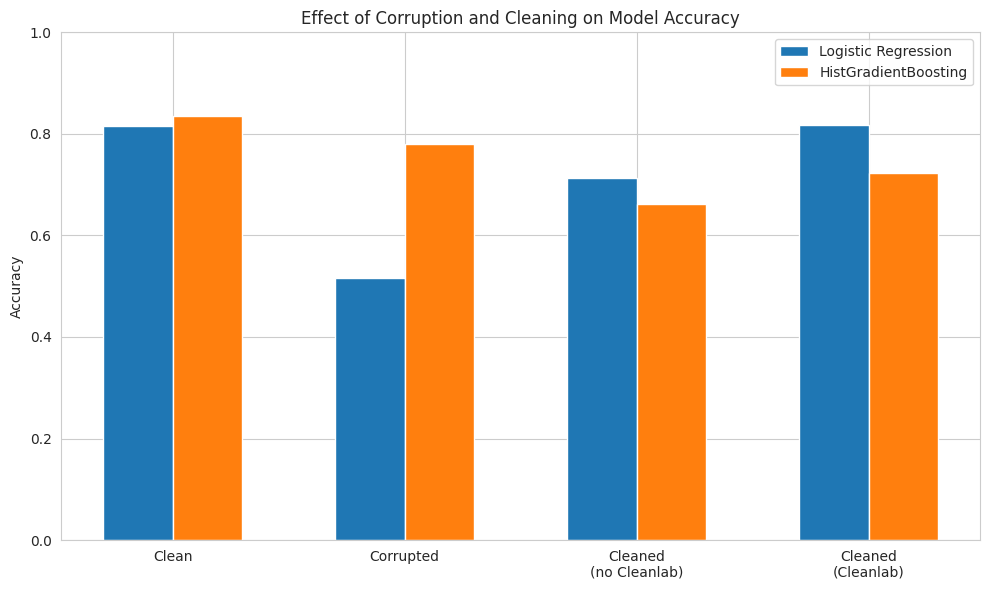

In [11]:
import matplotlib.pyplot as plt
import numpy as np

logreg_acc = [accuracy_reg_og, accuracy_reg_cat, accuracy_reg_cl, accuracy_reg_cleanlab]
histgb_acc = [accuracy_gb_og, accuracy_gb_cor, accuracy_gb_cl, accuracy_gb_cleanlab]
labels = [
    "Clean",
    "Corrupted",
    "Cleaned\n(no Cleanlab)",
    "Cleaned\n(Cleanlab)",
]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width/2, logreg_acc, width, label="Logistic Regression")
ax.bar(x + width/2, histgb_acc, width, label="HistGradientBoosting")

ax.set_ylabel("Accuracy")
ax.set_title("Effect of Corruption and Cleaning on Model Accuracy")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(WORK_DIR, 'results/figures/model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

## Alternative Corruption Method (Optional)

This section shows a manual corruption approach using random character injection and numeric scaling. This was an earlier experiment - the main results above use the Jenga library instead.

You can skip this cell if you're just reproducing the main results.

In [12]:
import random
import csv
import pandas as pd
import sys
sys.path.append(os.path.join(WORK_DIR, 'python_scripts'))

input_csv = os.path.join(WORK_DIR, 'data/baseline/adult.csv')
output_csv = os.path.join(WORK_DIR, 'data/corrupted/adult_corrupted_text_2.csv')

fraction_corrupt = 0.1
chars_to_inject = ['#','@','!','x','a']
negate_fraction = 0.1

numeric_cols = numeric_features
categorical_cols = categorical_features

with open(input_csv, newline='', encoding='utf-8') as f:
    reader = list(csv.reader(f))
    header = reader[0]
    rows = reader[1:]

col_to_idx = {col: i for i, col in enumerate(header)}
print(col_to_idx)

for row in rows:
    for col_name in numeric_cols:
        try:
            col_idx = col_to_idx[col_name]
            cell = row[col_idx]
            val = float(cell)
        except:
            continue

        if random.random() < negate_fraction:
            val = -abs(val)

        if random.random() < fraction_corrupt:
            factor = random.uniform(0.5, 10.0)
            val = val * factor

        if random.random() < fraction_corrupt:
            row[col_idx] = '?'
            continue

        if random.random() < fraction_corrupt:
            row[col_idx] = str(val) + random.choice(chars_to_inject)
        else:
            row[col_idx] = str(val)

for row in rows:
    for col_idx in categorical_cols:
        if random.random() < fraction_corrupt:
            col_idx = col_to_idx[col_idx]
            val = str(row[col_idx])
            n_chars = random.choice([1,2])
            for _ in range(n_chars):
                pos = random.randint(0, len(val))
                val = val[:pos] + random.choice(chars_to_inject) + val[pos:]
            row[col_idx] = val

with open(output_csv, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)

print(f"Corrupted CSV saved to {output_csv}")

df_corrupt = pd.read_csv(output_csv)

y = df_corrupt['class']
X = df_corrupt.drop(columns=['class'])

print(f"X shape: {X.shape}, y shape: {y.shape}")

{'age': 0, 'workclass': 1, 'fnlwgt': 2, 'education': 3, 'education-num': 4, 'marital-status': 5, 'occupation': 6, 'relationship': 7, 'race': 8, 'sex': 9, 'capital-gain': 10, 'capital-loss': 11, 'hours-per-week': 12, 'native-country': 13, 'class': 14}
Corrupted CSV saved to /content/drive/MyDrive/adults-dataset-categorical-numerical/data/corrupted/adult_corrupted_text_2.csv
X shape: (48842, 14), y shape: (48842,)


## Verification Check

This cell verifies that all corrupted/cleaned CSV files were created and that the results logger captured all experiments correctly.

Expected outputs:
- 13 CSV files (corrupted/cleaned data for both models)
- 10 logged experiments (5 per model: baseline + 2 corrupted stages + 2 cleaned stages)

In [14]:
import pandas as pd
import os

print("="*60)
print("VERIFICATION: CSV FILES AND RESULTS")
print("="*60)

# Check corrupted CSV files
corrupted_dir = os.path.join(WORK_DIR, 'data/corrupted')
cleaned_dir = os.path.join(WORK_DIR, 'data/cleaned')
print("\n1. CORRUPTED/CLEANED CSV FILES:")
print("-" * 60)

expected_files = [
    ('corrupted', 'corrupted_numerical.csv'),
    ('corrupted', 'corrupted_category_shift.csv'),
    ('corrupted', 'corrupted_category_typo.csv'),
    ('corrupted', 'corrupted_missing_values.csv'),
    ('cleaned', 'cleaned_without_cleanlab.csv'),
    ('cleaned', 'cleaned_with_cleanlab.csv'),
    ('corrupted', 'gb_corrupted_numerical.csv'),
    ('corrupted', 'gb_corrupted_category_shift.csv'),
    ('corrupted', 'gb_corrupted_category_typo.csv'),
    ('corrupted', 'gb_corrupted_missing_values.csv'),
    ('corrupted', 'gb_corrupted_category_default.csv'),
    ('cleaned', 'gb_cleaned_without_cleanlab.csv'),
    ('cleaned', 'gb_cleaned_with_cleanlab.csv')
]

for directory, file in expected_files:
    filepath = os.path.join(WORK_DIR, f'data/{directory}', file)
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        print(f" {file:45s} | {len(df):6d} rows | {len(df.columns)} cols")
    else:
        print(f" {file:45s} | MISSING")

# Check BOTH results CSV files
results_files = {
    'LogisticRegression': os.path.join(WORK_DIR, 'results/ALL_RESULTS_ADULT_COMBINED.csv'),
    'HistGradientBoosting': os.path.join(WORK_DIR, 'results/ALL_RESULTS_ADULT_COMBINED_GB_2.csv')
}

print("\n2. RESULTS CSV FILES:")
print("-" * 60)

all_results = []
for model_name, results_path in results_files.items():
    print(f"\nChecking {model_name} results:")
    if os.path.exists(results_path):
        df_results = pd.read_csv(results_path)
        print(f"  Found: {len(df_results)} experiments logged")
        all_results.append(df_results)
    else:
        print(f"  MISSING: {results_path}")

if all_results:
    # Combine all results
    df_combined = pd.concat(all_results, ignore_index=True)

    print("\n" + "-" * 60)
    print("COMBINED RESULTS:")
    print("\nBreakdown by model:")
    print(df_combined.groupby('model').size())

    print("\nBreakdown by cleaning level:")
    print(df_combined.groupby('cleaning_name').size())

    print("\nFull results summary:")
    print(df_combined[['model', 'experiment', 'cleaning_name', 'accuracy', 'f1', 'rows_dropped']].to_string(index=False))

    print("\n" + "="*60)
    print("EXPECTED: 10 total experiments")
    print(f"- LogisticRegression: 5 (baseline + 2 corruptions + 2 cleanings)")
    print(f"- HistGradientBoosting: 5 (baseline + 2 corruptions + 2 cleanings)")

    # Get unique experiments (to handle reruns)
    unique_experiments = df_combined.drop_duplicates(subset=['model', 'cleaning_name'], keep='last')
    print(f"\nACTUAL UNIQUE: {len(unique_experiments)} experiments")

    print("\nUnique experiments by model:")
    print(unique_experiments.groupby('model').size())

    expected_experiments = [
        ('LogisticRegression', '0_Baseline'),
        ('LogisticRegression', '1_Corrupted_Numerical'),
        ('LogisticRegression', '1_Corrupted_All'),
        ('LogisticRegression', '2_Cleaned_NoCleanlab'),
        ('LogisticRegression', '3_Cleaned_Cleanlab'),
        ('HistGradientBoosting', '0_Baseline'),
        ('HistGradientBoosting', '1_Corrupted_Numerical'),
        ('HistGradientBoosting', '1_Corrupted_All'),
        ('HistGradientBoosting', '2_Cleaned_NoCleanlab'),
        ('HistGradientBoosting', '3_Cleaned_Cleanlab'),
    ]

    logged = set(zip(unique_experiments['model'], unique_experiments['cleaning_name']))
    missing = [exp for exp in expected_experiments if exp not in logged]

    if not missing:
        print("\nALL EXPERIMENTS LOGGED CORRECTLY!")
    else:
        print(f"\nMissing {len(missing)} experiments:")
        for model, level in missing:
            print(f"  {model} | {level}")
else:
    print("\nNo results files found!")

print("\n" + "="*60)

VERIFICATION: CSV FILES AND RESULTS

1. CORRUPTED/CLEANED CSV FILES:
------------------------------------------------------------
 corrupted_numerical.csv                       |  22000 rows | 12 cols
 corrupted_category_shift.csv                  |  22000 rows | 12 cols
 corrupted_category_typo.csv                   |  22000 rows | 12 cols
 corrupted_missing_values.csv                  |  22000 rows | 12 cols
 cleaned_without_cleanlab.csv                  |  21998 rows | 15 cols
 cleaned_with_cleanlab.csv                     |  19837 rows | 15 cols
 gb_corrupted_numerical.csv                    |  22000 rows | 12 cols
 gb_corrupted_category_shift.csv               |  22000 rows | 12 cols
 gb_corrupted_category_typo.csv                |  22000 rows | 12 cols
 gb_corrupted_missing_values.csv               |  22000 rows | 12 cols
 gb_corrupted_category_default.csv             |  22000 rows | 12 cols
 gb_cleaned_without_cleanlab.csv               |  21336 rows | 49 cols
 gb_cleaned_with_c

## Statistical Analysis

We run four statistical tests to evaluate the effectiveness of different cleaning strategies:

1. **Best Method Per Model** - Which cleaning level achieves highest accuracy
2. **Accuracy Recovery** - How much of the corruption damage can we recover
3. **Cost-Benefit** - Is the accuracy gain worth the data loss from Cleanlab
4. **Model Comparison** - Which model handles corruption better

**Note:** Multiple runs were recorded during experimentation. We use the mean across runs for more robust empirical insights, reducing the impact of random variation and the analysis gets emperically strong with each run. But in case, this is a loca environment and the first run, it would naturaly have just one run recorded for the anaysis.

In [15]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, ttest_rel

# Paths
RESULTS_CSV = os.path.join(WORK_DIR, "results/ALL_RESULTS_ADULT_COMBINED.csv")
RESULTS_CSV_GB = os.path.join(WORK_DIR, "results/ALL_RESULTS_ADULT_COMBINED_GB_2.csv")
OUT_DIR = os.path.join(WORK_DIR, "results/statistical_tests")
os.makedirs(OUT_DIR, exist_ok=True)

print("="*60)
print("STATISTICAL TESTS FOR ADULT DATASET")
print("="*60)

# Load and combine results from both files
df_lr = pd.read_csv(RESULTS_CSV)
df_gb = pd.read_csv(RESULTS_CSV_GB)
df = pd.concat([df_lr, df_gb], ignore_index=True)

print(f"\nLoaded {len(df)} total experiments")
print(f"Using mean across multiple runs for robust estimates")

# ---------- Test 1: Best method per model ----------
print("\n" + "="*60)
print("TEST 1: Best Cleaning Level Per Model")
print("="*60)

best_per_model = []
for model in df['model'].unique():
    model_df = df[df['model'] == model].copy()
    # Group by cleaning_name and take mean
    mean_df = model_df.groupby('cleaning_name')[['accuracy', 'f1']].mean().reset_index()
    best_row = mean_df.loc[mean_df['accuracy'].idxmax()]
    best_per_model.append({
        'model': model,
        'best_level': best_row['cleaning_name'],
        'best_accuracy': best_row['accuracy'],
        'best_f1': best_row['f1']
    })

df_best = pd.DataFrame(best_per_model)
df_best.to_csv(os.path.join(OUT_DIR, "01_best_per_model.csv"), index=False)
print(df_best.to_string(index=False))

# ---------- Test 2: Accuracy recovery analysis ----------
print("\n" + "="*60)
print("TEST 2: Accuracy Recovery Analysis")
print("="*60)

improvements = []
for model in df['model'].unique():
    model_df = df[df['model'] == model].copy()

    # Calculate means for each cleaning level
    baseline_acc = model_df[model_df['cleaning_name'] == '0_Baseline']['accuracy'].mean()
    corrupted_acc = model_df[model_df['cleaning_name'] == '1_Corrupted_All']['accuracy'].mean()
    cleaned_no_cl = model_df[model_df['cleaning_name'] == '2_Cleaned_NoCleanlab']['accuracy'].mean()
    cleaned_cl = model_df[model_df['cleaning_name'] == '3_Cleaned_Cleanlab']['accuracy'].mean()

    damage = baseline_acc - corrupted_acc
    recovery_no_cl = cleaned_no_cl - corrupted_acc
    recovery_cl = cleaned_cl - corrupted_acc

    recovery_pct_no_cl = (recovery_no_cl / damage * 100) if damage > 0 else 0
    recovery_pct_cl = (recovery_cl / damage * 100) if damage > 0 else 0

    improvements.append({
        'model': model,
        'baseline_acc': baseline_acc,
        'corrupted_acc': corrupted_acc,
        'damage': damage,
        'cleaned_no_cleanlab_acc': cleaned_no_cl,
        'cleaned_cleanlab_acc': cleaned_cl,
        'recovery_no_cleanlab': recovery_no_cl,
        'recovery_cleanlab': recovery_cl,
        'recovery_pct_no_cleanlab': recovery_pct_no_cl,
        'recovery_pct_cleanlab': recovery_pct_cl,
        'cleanlab_advantage': cleaned_cl - cleaned_no_cl
    })

df_improvements = pd.DataFrame(improvements)
df_improvements.to_csv(os.path.join(OUT_DIR, "02_accuracy_recovery.csv"), index=False)
print(df_improvements.to_string(index=False))

# ---------- Test 3: Cost-benefit ----------
print("\n" + "="*60)
print("TEST 3: Cost-Benefit Analysis")
print("="*60)

cost_benefit = []
for model in df['model'].unique():
    model_df = df[df['model'] == model].copy()

    # Calculate means
    no_cl_df = model_df[model_df['cleaning_name'] == '2_Cleaned_NoCleanlab']
    cl_df = model_df[model_df['cleaning_name'] == '3_Cleaned_Cleanlab']

    no_cl_acc = no_cl_df['accuracy'].mean()
    cl_acc = cl_df['accuracy'].mean()
    rows_dropped_mean = cl_df['rows_dropped'].mean()

    acc_gain = cl_acc - no_cl_acc

    cost_benefit.append({
        'model': model,
        'accuracy_no_cleanlab': no_cl_acc,
        'accuracy_cleanlab': cl_acc,
        'accuracy_gain': acc_gain,
        'rows_dropped': rows_dropped_mean,
        'gain_per_1000_rows_dropped': (acc_gain / abs(rows_dropped_mean) * 1000) if rows_dropped_mean != 0 else np.nan
    })

df_cost = pd.DataFrame(cost_benefit)
df_cost.to_csv(os.path.join(OUT_DIR, "03_cost_benefit_cleanlab.csv"), index=False)
print(df_cost.to_string(index=False))

# ---------- Test 4: Model comparison ----------
print("\n" + "="*60)
print("TEST 4: Model Comparison")
print("="*60)

levels = ['0_Baseline', '1_Corrupted_All', '2_Cleaned_NoCleanlab', '3_Cleaned_Cleanlab']
model_comparison = []

for level in levels:
    logreg_acc = df[(df['model'] == 'LogisticRegression') & (df['cleaning_name'] == level)]['accuracy'].mean()
    gradboost_acc = df[(df['model'] == 'HistGradientBoosting') & (df['cleaning_name'] == level)]['accuracy'].mean()

    model_comparison.append({
        'cleaning_level': level,
        'logreg_accuracy': logreg_acc,
        'gradboost_accuracy': gradboost_acc,
        'difference': gradboost_acc - logreg_acc,
        'better_model': 'GradientBoosting' if gradboost_acc > logreg_acc else 'LogisticRegression'
    })

df_comparison = pd.DataFrame(model_comparison)
df_comparison.to_csv(os.path.join(OUT_DIR, "04_model_comparison.csv"), index=False)
print(df_comparison.to_string(index=False))

# ---------- Summary ----------
print("\n" + "="*60)
print("SUMMARY")
print("="*60)

summary = {
    'n_models': int(df['model'].nunique()),
    'n_cleaning_levels': int(df['cleaning_name'].nunique()),
    'total_runs': len(df),
    'avg_accuracy_baseline': float(df[df['cleaning_name'] == '0_Baseline']['accuracy'].mean()),
    'avg_accuracy_corrupted': float(df[df['cleaning_name'] == '1_Corrupted_All']['accuracy'].mean()),
    'avg_damage': float(df_improvements['damage'].mean()),
    'avg_recovery_pct_cleanlab': float(df_improvements['recovery_pct_cleanlab'].mean()),
    'cleanlab_better_count': int((df_improvements['cleanlab_advantage'] > 0).sum())
}

df_summary = pd.Series(summary)
df_summary.to_csv(os.path.join(OUT_DIR, "00_SUMMARY.csv"), header=False)

print("\nKey Findings:")
for key, val in summary.items():
    print(f"  {key}: {val}")

print("\n" + "="*60)
print("All tests completed")
print(f"Results saved to: {OUT_DIR}")
print("="*60)

print("\nGenerated files:")
for f in sorted(os.listdir(OUT_DIR)):
    print(f"  - {f}")

STATISTICAL TESTS FOR ADULT DATASET

Loaded 75 total experiments
Using mean across multiple runs for robust estimates

TEST 1: Best Cleaning Level Per Model
               model best_level  best_accuracy  best_f1
  LogisticRegression 0_Baseline       0.810691 0.812550
HistGradientBoosting 0_Baseline       0.835976 0.835924

TEST 2: Accuracy Recovery Analysis
               model  baseline_acc  corrupted_acc   damage  cleaned_no_cleanlab_acc  cleaned_cleanlab_acc  recovery_no_cleanlab  recovery_cleanlab  recovery_pct_no_cleanlab  recovery_pct_cleanlab  cleanlab_advantage
  LogisticRegression      0.810691       0.568086 0.242604                 0.686436              0.798068              0.118350           0.229981                 48.782983              94.796920            0.111632
HistGradientBoosting      0.835976       0.782190 0.053786                 0.642288              0.724729             -0.139902          -0.057461               -260.110433            -106.833385            

## TensorFlow Data Validation (TFDV) Setup

TFDV is a production-grade data validation library from Google's TFX ecosystem. We use it to detect data quality issues that traditional validation might miss.

**Why TFDV for this project:**
- Detects schema violations, distribution drift, and missing value patterns
- Production-ready tool used in real ML pipelines
- Provides quantitative detectability scores for different corruption types

**Setup challenges:**
- TFDV requires specific TensorFlow versions (2.15.x with Python 3.11 or 2.16+ with Python 3.12)
- Not compatible with Windows (Linux/Mac or Colab required)
- Version mismatches between TensorFlow, tensorflow-metadata, and TFDV can cause installation failures

**Key finding from our analysis:**
TFDV shows dramatically different detection rates for structured vs unstructured data:
- **Adult dataset (structured):** 100% detection rate, 20.9 avg anomalies
- **Amazon dataset (text):** 22% detection rate, 0.67 avg anomalies
- This 33× difference validates why model-aware cleaning is essential for semantic corruptions

The installation below uses compatible versions that work in Google Colab's Python 3.11 environment.

In [16]:
# Upgrade pip first
!pip install --upgrade pip

# Install specific compatible versions
!pip install \
  tensorflow==2.15.1 \
  tensorflow-metadata==1.15.0 \
  tensorflow-data-validation==1.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 76.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you wa

## Verify TFDV Installation

Quick check to ensure all components are installed correctly and compatible.

In [1]:
import sys
import tensorflow as tf
import tensorflow_data_validation as tfdv

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("TFDV:", tfdv.__version__)
print("\nTFDV successfully installed")

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.15.1
TFDV: 1.15.1

TFDV successfully installed


## TFDV Analysis Pipeline

**Note:** If you just installed TFDV and the runtime restarted, make sure to re-run the Environment Setup and Import Libraries cells from the beginning of the notebook first to restore WORK_DIR and other variables.


We run TFDV on all corrupted datasets to measure how well traditional data validation detects our injected corruptions.

**Process:**
1. Load baseline data and generate schema
2. Add proxy features (missing indicators, negative value flags) to help TFDV detect issues
3. For each corrupted file, validate against baseline schema
4. Count anomaly types (schema violations, completeness issues, distribution drift)
5. Calculate weighted TFDV detectability score

**Output:** CSV with TFDV scores and anomaly counts per corruption type, plus detailed anomaly reports.

In [4]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow_data_validation as tfdv
from tensorflow_metadata.proto.v0 import anomalies_pb2

# Paths
BASELINE_CSV = os.path.join(WORK_DIR, "data/baseline/adult_for_manual_edit.csv")
CORRUPT_DIR = os.path.join(WORK_DIR, "data/corrupted")
OUT_DIR = os.path.join(WORK_DIR, "results/tfdv_analysis")
os.makedirs(OUT_DIR, exist_ok=True)

def add_numeric_proxies(df: pd.DataFrame) -> pd.DataFrame:
    """Add proxy features for Adult dataset to help TFDV detect issues"""
    df = df.copy()

    # Numeric features statistics
    numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

    for col in numeric_features:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[f'{col}_is_missing'] = df[col].isna().astype(np.int64)
            df[f'{col}_is_negative'] = (df[col] < 0).fillna(False).astype(np.int64)

    # Categorical features - add missing indicators
    categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

    for col in categorical_features:
        if col in df.columns:
            df[col] = df[col].astype(str)
            df[f'{col}_is_missing'] = (df[col].isin(['', 'nan', 'None', '?'])).astype(np.int64)

    # Total missing count per row
    missing_cols = [c for c in df.columns if '_is_missing' in c]
    if missing_cols:
        df['total_missing_features'] = df[missing_cols].sum(axis=1).astype(np.int64)

    return df

def load_csv_for_tfdv(path: str) -> pd.DataFrame:
    """Load CSV and add proxy features for TFDV analysis"""
    df = pd.read_csv(path)
    return add_numeric_proxies(df)

def count_anomalies(anom: anomalies_pb2.Anomalies):
    """Count different types of anomalies detected by TFDV"""
    total = 0
    type_viol = 0
    completeness = 0
    drift = 0

    for feat_name, feat_anom in anom.anomaly_info.items():
        if not feat_anom.reason:
            continue
        for r in feat_anom.reason:
            total += 1
            s = (r.short_description or "") + " " + (r.description or "")
            s = s.lower()

            if "type" in s:
                type_viol += 1
            if "missing" in s or "completeness" in s or "presence" in s:
                completeness += 1
            if "drift" in s or "skew" in s or "distribution" in s:
                drift += 1

    return {
        "n_anomalies_total": total,
        "n_type_violations": type_viol,
        "n_completeness_related": completeness,
        "n_drift_related": drift,
    }

def tfdv_score(counts: dict) -> float:
    """Calculate weighted TFDV score in [0, 1)"""
    w_type = 0.30
    w_comp = 0.30
    w_drift = 0.40
    raw = (
        w_type * counts["n_type_violations"]
        + w_comp * counts["n_completeness_related"]
        + w_drift * counts["n_drift_related"]
    )
    return float(1.0 - np.exp(-raw / 3.0))

print("="*60)
print("TFDV ANALYSIS FOR ADULT DATASET")
print("="*60)

print("\nLoading baseline:", BASELINE_CSV)
df_base = load_csv_for_tfdv(BASELINE_CSV)

print(f"Baseline shape: {df_base.shape}")
print(f"Baseline columns: {list(df_base.columns)}")

# Generate statistics and infer schema from baseline
base_stats = tfdv.generate_statistics_from_dataframe(df_base)
schema = tfdv.infer_schema(base_stats)

# Save schema
schema_path = os.path.join(OUT_DIR, "baseline_schema.pbtxt")
tfdv.write_schema_text(schema, schema_path)
print(f"\nSchema saved to: {schema_path}")

# Process all corrupted files (exclude cleaned files)
results = []
corrupt_files = sorted([
    f for f in os.listdir(CORRUPT_DIR)
    if f.endswith(".csv") and "cleaned" not in f.lower()
])

print(f"\nFound {len(corrupt_files)} corrupted files")
print("Processing...")

for fname in corrupt_files:
    exp = fname.replace(".csv", "")
    fpath = os.path.join(CORRUPT_DIR, fname)

    print(f"  - {exp}")

    df_c = load_csv_for_tfdv(fpath)
    cur_stats = tfdv.generate_statistics_from_dataframe(df_c)

    # Validate against baseline schema and statistics
    anom = tfdv.validate_statistics(
        statistics=cur_stats,
        schema=schema,
        previous_statistics=base_stats
    )

    counts = count_anomalies(anom)
    score = tfdv_score(counts)

    # Calculate additional metrics
    total_missing = float(df_c['total_missing_features'].mean()) if 'total_missing_features' in df_c.columns else 0

    results.append({
        "experiment": exp,
        "n_rows": int(len(df_c)),
        "n_anomalies_total": counts["n_anomalies_total"],
        "type_violations": counts["n_type_violations"],
        "completeness_related": counts["n_completeness_related"],
        "drift_related": counts["n_drift_related"],
        "tfdv_score": score,
        "avg_missing_per_row": total_missing,
    })

    # Save per-experiment anomalies
    anom_path = os.path.join(OUT_DIR, f"anomalies_{exp}.pbtxt")
    tfdv.write_anomalies_text(anom, anom_path)

# Create results dataframe
df_out = pd.DataFrame(results).sort_values("tfdv_score", ascending=False)
out_csv = os.path.join(OUT_DIR, "TFDV_Analysis_Adult.csv")
df_out.to_csv(out_csv, index=False)

# Summary
summary = {
    "n_experiments": int(df_out.shape[0]),
    "mean_tfdv_score": float(df_out["tfdv_score"].mean()) if len(df_out) else None,
    "median_tfdv_score": float(df_out["tfdv_score"].median()) if len(df_out) else None,
    "top_5_by_score": df_out[["experiment", "tfdv_score", "n_anomalies_total"]].head(5).to_dict(orient="records"),
    "schema_path": schema_path,
    "csv_path": out_csv,
    "out_dir": OUT_DIR,
}

summary_path = os.path.join(OUT_DIR, "TFDV_Analysis_Adult_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("\n" + "="*60)
print("RESULTS")
print("="*60)
print(f"\nAnalysis complete")
print(f"Results CSV: {out_csv}")
print(f"Summary JSON: {summary_path}")

print("\nTop experiments by TFDV score:")
print(df_out[["experiment", "tfdv_score", "n_anomalies_total", "type_violations", "drift_related"]].head(10))

print(f"\nOutput directory: {OUT_DIR}")
print(f"Generated {len(os.listdir(OUT_DIR))} files")

TFDV ANALYSIS FOR ADULT DATASET

Loading baseline: /content/drive/MyDrive/adults-dataset-categorical-numerical/data/baseline/adult_for_manual_edit.csv
Baseline shape: (48842, 29)
Baseline columns: ['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'income', 'age_is_missing', 'age_is_negative', 'education-num_is_missing', 'education-num_is_negative', 'capital-gain_is_missing', 'capital-gain_is_negative', 'capital-loss_is_missing', 'capital-loss_is_negative', 'hours-per-week_is_missing', 'hours-per-week_is_negative', 'workclass_is_missing', 'marital-status_is_missing', 'occupation_is_missing', 'relationship_is_missing', 'race_is_missing', 'sex_is_missing', 'total_missing_features']

Schema saved to: /content/drive/MyDrive/adults-dataset-categorical-numerical/results/tfdv_analysis/baseline_schema.pbtxt

Found 10 corrupted files
Processing...
  - adult_corrupted_text_2
  - corrupted_category

## TFDV Comparison Visualization

Comparing TFDV detection effectiveness between Adult (structured) and Amazon (text) datasets.

This visualization demonstrates a key finding: schema-based validation tools like TFDV are highly effective at detecting structural corruptions (missing values, type violations) but struggle with semantic corruptions (swapped labels, text misalignment) that preserve the data schema.

The comparison validates why model-aware cleaning strategies are necessary alongside traditional validation tools.

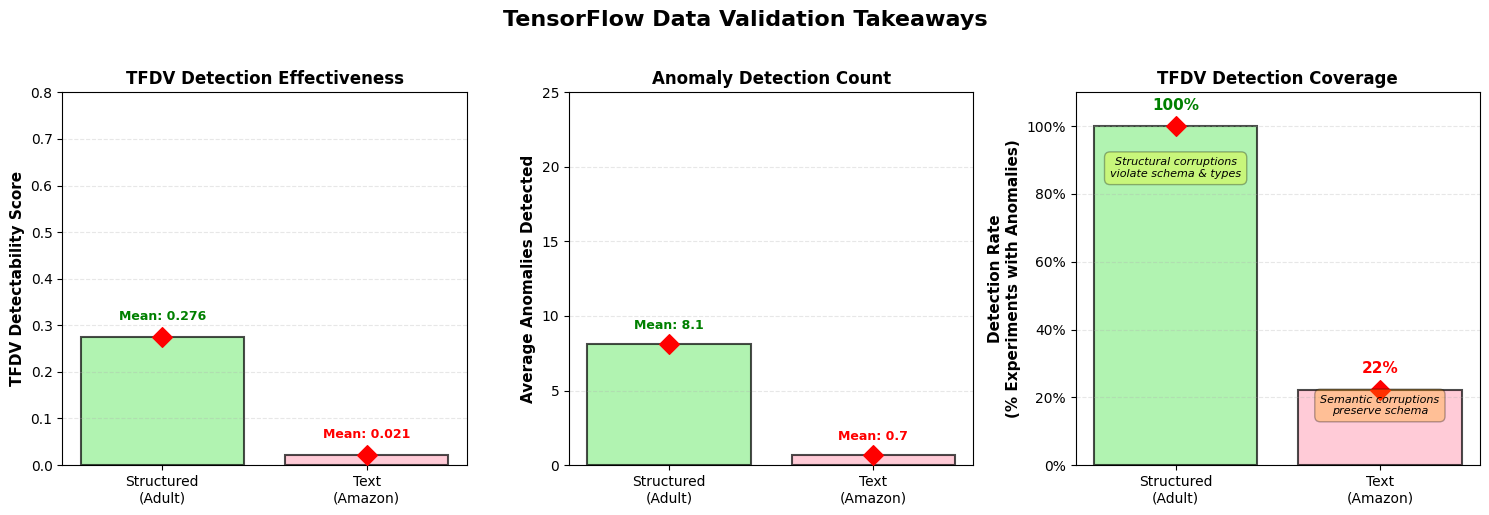

TFDV COMPARISON SUMMARY

Adult (Structured Data):
  TFDV Score: 0.276
  Avg Anomalies: 8.1
  Detection Rate: 100%

Amazon (Text Data):
  TFDV Score: 0.021
  Avg Anomalies: 0.7
  Detection Rate: 22%

Key Differences:
  TFDV Score: 13.0x higher for Adult
  Anomalies: 12.2x more for Adult
  Detection Rate: 78% higher for Adult

Figure saved to: /content/drive/MyDrive/adults-dataset-categorical-numerical/figures/tfdv_analysis


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Create figures directory
figures_dir = os.path.join(WORK_DIR, 'figures/tfdv_analysis')
os.makedirs(figures_dir, exist_ok=True)

# Load TFDV results from both datasets
df_adult = pd.read_csv(os.path.join(WORK_DIR, 'results/tfdv_analysis/TFDV_Analysis_Adult.csv'))
df_amazon = pd.read_csv(os.path.join(WORK_DIR, 'results/tfdv_analysis/TFDV_Analysis_Amazon.csv'))

# Calculate summary statistics
adult_tfdv_mean = df_adult['tfdv_score'].mean()
adult_anomalies_mean = df_adult['n_anomalies_total'].mean()
adult_detection_rate = (df_adult['n_anomalies_total'] > 0).mean()

amazon_tfdv_mean = df_amazon['tfdv_score'].mean()
amazon_anomalies_mean = df_amazon['n_anomalies_total'].mean()
amazon_detection_rate = (df_amazon['n_anomalies_total'] > 0).mean()

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('TensorFlow Data Validation Takeaways', fontsize=16, fontweight='bold', y=1.02)

# Subplot 1: TFDV Detection Effectiveness
ax1 = axes[0]
datasets = ['Structured\n(Adult)', 'Text\n(Amazon)']
tfdv_means = [adult_tfdv_mean, amazon_tfdv_mean]
colors = ['#90EE90', '#FFB6C6']

bars1 = ax1.bar(datasets, tfdv_means, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.scatter(datasets, tfdv_means, color='red', s=100, zorder=3, marker='D')
ax1.set_ylabel('TFDV Detectability Score', fontsize=11, fontweight='bold')
ax1.set_title('TFDV Detection Effectiveness', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 0.8)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars1, tfdv_means)):
    label = f"Mean: {val:.3f}"
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.03, label,
             ha='center', va='bottom', fontsize=9, fontweight='bold',
             color='green' if i == 0 else 'red')

# Subplot 2: Anomalies Detected
ax2 = axes[1]
anomalies_means = [adult_anomalies_mean, amazon_anomalies_mean]

bars2 = ax2.bar(datasets, anomalies_means, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.scatter(datasets, anomalies_means, color='red', s=100, zorder=3, marker='D')
ax2.set_ylabel('Average Anomalies Detected', fontsize=11, fontweight='bold')
ax2.set_title('Anomaly Detection Count', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 25)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, anomalies_means)):
    label = f"Mean: {val:.1f}"
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.8, label,
             ha='center', va='bottom', fontsize=9, fontweight='bold',
             color='green' if i == 0 else 'red')

# Subplot 3: Detection Rate
ax3 = axes[2]
detection_rates = [adult_detection_rate, amazon_detection_rate]

bars3 = ax3.bar(datasets, detection_rates, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.scatter(datasets, detection_rates, color='red', s=100, zorder=3, marker='D')
ax3.set_ylabel('Detection Rate\n(% Experiments with Anomalies)', fontsize=11, fontweight='bold')
ax3.set_title('TFDV Detection Coverage', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 1.1)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y*100)}%'))
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage labels
for i, (bar, val) in enumerate(zip(bars3, detection_rates)):
    label = f"{val*100:.0f}%"
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.04, label,
             ha='center', va='bottom', fontsize=11, fontweight='bold',
             color='green' if i == 0 else 'red')

# Add annotations explaining the difference
ax3.text(0, 0.85, 'Structural corruptions\nviolate schema & types',
         ha='center', fontsize=8, style='italic',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))
ax3.text(1, 0.15, 'Semantic corruptions\npreserve schema',
         ha='center', fontsize=8, style='italic',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='orange', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'tfdv_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("="*60)
print("TFDV COMPARISON SUMMARY")
print("="*60)
print(f"\nAdult (Structured Data):")
print(f"  TFDV Score: {adult_tfdv_mean:.3f}")
print(f"  Avg Anomalies: {adult_anomalies_mean:.1f}")
print(f"  Detection Rate: {adult_detection_rate*100:.0f}%")

print(f"\nAmazon (Text Data):")
print(f"  TFDV Score: {amazon_tfdv_mean:.3f}")
print(f"  Avg Anomalies: {amazon_anomalies_mean:.1f}")
print(f"  Detection Rate: {amazon_detection_rate*100:.0f}%")

print(f"\nKey Differences:")
print(f"  TFDV Score: {adult_tfdv_mean/amazon_tfdv_mean:.1f}x higher for Adult")
print(f"  Anomalies: {adult_anomalies_mean/amazon_anomalies_mean:.1f}x more for Adult")
print(f"  Detection Rate: {(adult_detection_rate-amazon_detection_rate)*100:.0f}% higher for Adult")

print(f"\nFigure saved to: {figures_dir}")
print("="*60)

## Results Visualization

Creating figures to visualize model performance across corruption and cleaning stages.

CREATING VISUALIZATIONS

Data: 10 unique experiments
Models: LogisticRegression, HistGradientBoosting

Figure 1: Model comparison across stages...


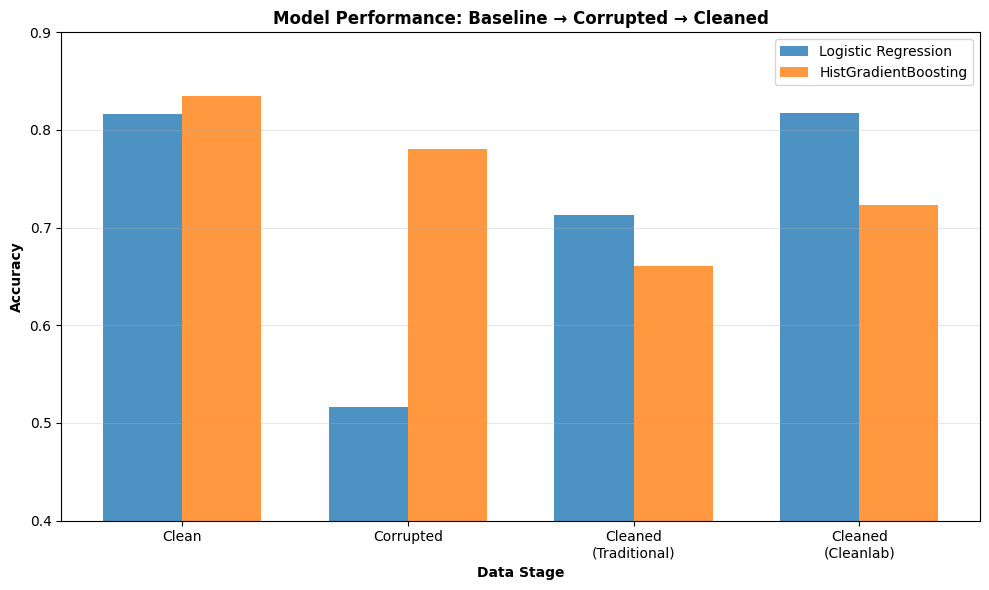

  Saved: model_comparison_stages.png

Figure 2: Accuracy recovery analysis...


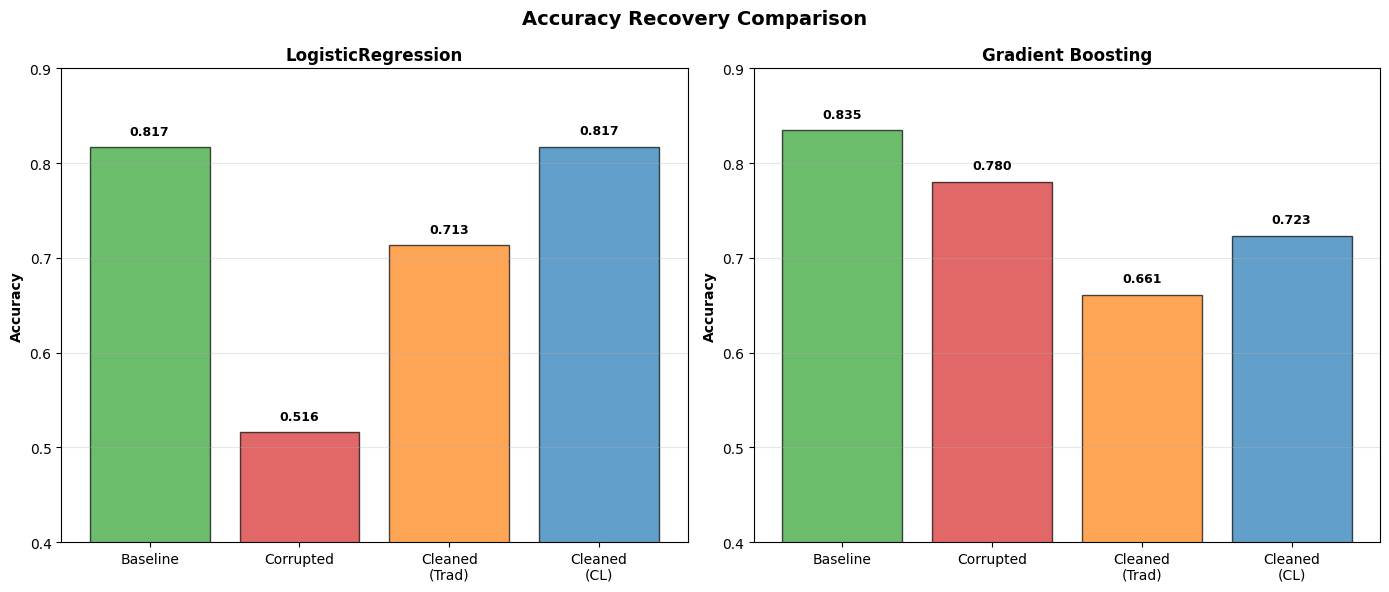

  Saved: recovery_analysis.png

Figure 3: Cost-benefit trade-off...


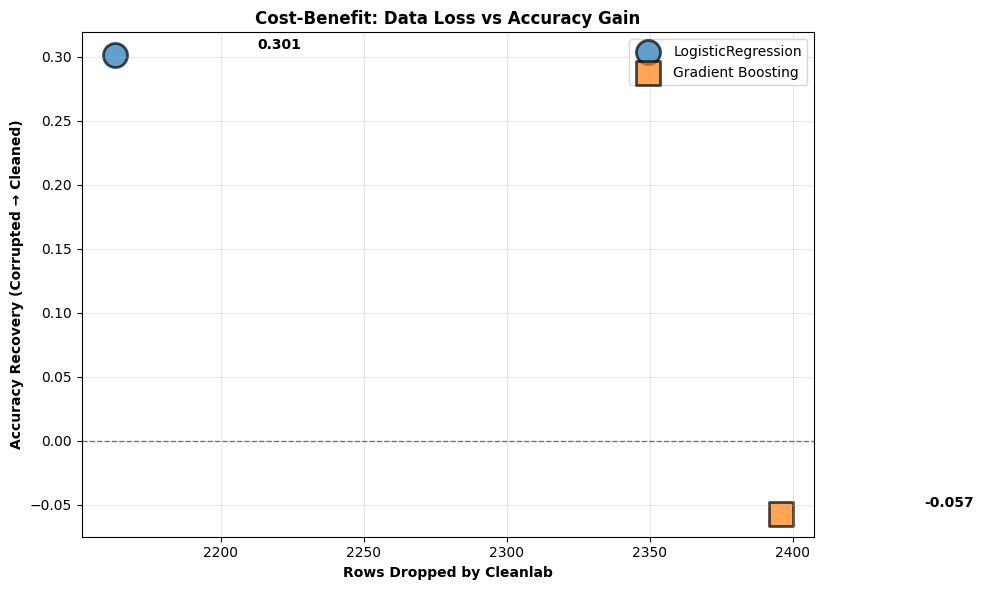

  Saved: cost_benefit.png

All visualizations complete
Saved to: /content/drive/MyDrive/adults-dataset-categorical-numerical/figures/performance_analysis


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create figures directory
figures_dir = os.path.join(WORK_DIR, 'figures/performance_analysis')
os.makedirs(figures_dir, exist_ok=True)

# Load combined results from both models
df_lr = pd.read_csv(os.path.join(WORK_DIR, 'results/ALL_RESULTS_ADULT_COMBINED.csv'))
df_gb = pd.read_csv(os.path.join(WORK_DIR, 'results/ALL_RESULTS_ADULT_COMBINED_GB_2.csv'))
df = pd.concat([df_lr, df_gb], ignore_index=True)

# Keep only last run for each model/cleaning_name
df = df.drop_duplicates(subset=['model', 'cleaning_name'], keep='last')

print("="*60)
print("CREATING VISUALIZATIONS")
print("="*60)
print(f"\nData: {len(df)} unique experiments")
print(f"Models: {', '.join(df['model'].unique())}")

# Figure 1: Model Comparison Across Stages
print("\nFigure 1: Model comparison across stages...")

fig, ax = plt.subplots(figsize=(10, 6))

stages = ['0_Baseline', '1_Corrupted_All', '2_Cleaned_NoCleanlab', '3_Cleaned_Cleanlab']
stage_labels = ['Clean', 'Corrupted', 'Cleaned\n(Traditional)', 'Cleaned\n(Cleanlab)']

logreg_accs = [df[(df['model']=='LogisticRegression') & (df['cleaning_name']==s)]['accuracy'].values[0] for s in stages]
gradboost_accs = [df[(df['model']=='HistGradientBoosting') & (df['cleaning_name']==s)]['accuracy'].values[0] for s in stages]

x = np.arange(len(stage_labels))
width = 0.35

bars1 = ax.bar(x - width/2, logreg_accs, width, label='Logistic Regression', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x + width/2, gradboost_accs, width, label='HistGradientBoosting', color='#ff7f0e', alpha=0.8)

ax.set_xlabel('Data Stage', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Model Performance: Baseline → Corrupted → Cleaned', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stage_labels)
ax.legend()
ax.set_ylim(0.4, 0.9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'model_comparison_stages.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"  Saved: model_comparison_stages.png")

# Figure 2: Recovery Analysis Side-by-Side
print("\nFigure 2: Accuracy recovery analysis...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, model in enumerate(['LogisticRegression', 'HistGradientBoosting']):
    ax = axes[idx]
    model_data = df[df['model'] == model]

    baseline = model_data[model_data['cleaning_name']=='0_Baseline']['accuracy'].values[0]
    corrupted = model_data[model_data['cleaning_name']=='1_Corrupted_All']['accuracy'].values[0]
    no_cleanlab = model_data[model_data['cleaning_name']=='2_Cleaned_NoCleanlab']['accuracy'].values[0]
    cleanlab = model_data[model_data['cleaning_name']=='3_Cleaned_Cleanlab']['accuracy'].values[0]

    stages_short = ['Baseline', 'Corrupted', 'Cleaned\n(Trad)', 'Cleaned\n(CL)']
    accs = [baseline, corrupted, no_cleanlab, cleanlab]
    colors = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']

    bars = ax.bar(stages_short, accs, color=colors, alpha=0.7, edgecolor='black')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_title(f'{model.replace("HistGradientBoosting", "Gradient Boosting")}', fontweight='bold')
    ax.set_ylim(0.4, 0.9)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, val in zip(bars, accs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

fig.suptitle('Accuracy Recovery Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'recovery_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"  Saved: recovery_analysis.png")

# Figure 3: Cost-Benefit Analysis
print("\nFigure 3: Cost-benefit trade-off...")

fig, ax = plt.subplots(figsize=(10, 6))

for model, color, marker in [('LogisticRegression', '#1f77b4', 'o'),
                              ('HistGradientBoosting', '#ff7f0e', 's')]:

    model_data = df[df['model'] == model]

    corrupted = model_data[model_data['cleaning_name']=='1_Corrupted_All']['accuracy'].values[0]
    cleanlab_row = model_data[model_data['cleaning_name']=='3_Cleaned_Cleanlab']

    cleanlab_acc = cleanlab_row['accuracy'].values[0]
    rows_dropped = abs(cleanlab_row['rows_dropped'].values[0])

    acc_recovery = cleanlab_acc - corrupted

    ax.scatter(rows_dropped, acc_recovery, s=300, color=color, alpha=0.7,
               edgecolors='black', linewidth=2, marker=marker,
               label=model.replace('HistGradientBoosting', 'Gradient Boosting'))

    # Add label with recovery percentage
    ax.text(rows_dropped + 50, acc_recovery + 0.005,
            f'{acc_recovery:.3f}', fontsize=10, fontweight='bold')

ax.set_xlabel('Rows Dropped by Cleanlab', fontweight='bold')
ax.set_ylabel('Accuracy Recovery (Corrupted → Cleaned)', fontweight='bold')
ax.set_title('Cost-Benefit: Data Loss vs Accuracy Gain', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='No improvement')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'cost_benefit.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"  Saved: cost_benefit.png")

print("\n" + "="*60)
print("All visualizations complete")
print(f"Saved to: {figures_dir}")
print("="*60)

## Generated Figures

All figures have been saved to `figures/performance_analysis/`:
- `model_comparison_stages.png` - Performance across all stages
- `recovery_analysis.png` - Side-by-side recovery comparison
- `cost_benefit.png` - Data loss vs accuracy trade-off

## Cost-Benefit Analysis

Evaluating the trade-off between accuracy improvement and data loss when using Cleanlab for label cleaning.

Cost-Benefit Analysis

Results:
               Model  Accuracy_Gain  Recovery_Pct  Rows_Dropped  Data_Loss_Pct  CB_Ratio
  LogisticRegression       0.301295    100.234306          2163       9.831818  3.064491
HistGradientBoosting      -0.056943   -104.164524          2396      10.890909 -0.522851


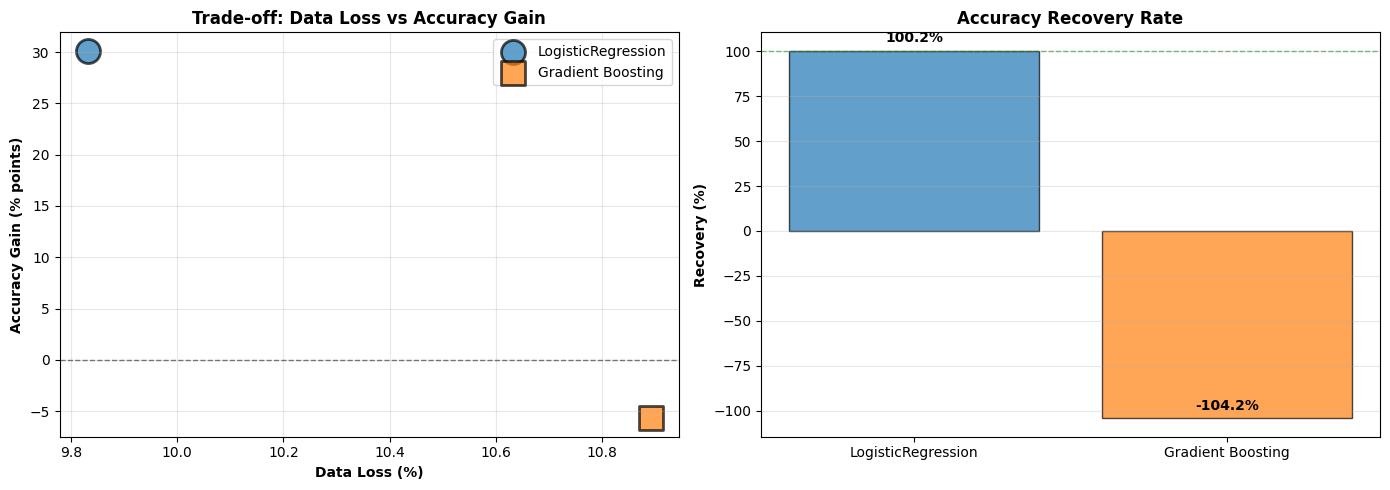


Figure saved to: /content/drive/MyDrive/adults-dataset-categorical-numerical/figures/cost_benefit


In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Create directories
figures_dir = os.path.join(WORK_DIR, 'figures/cost_benefit')
os.makedirs(figures_dir, exist_ok=True)

# Load combined results
df_lr = pd.read_csv(os.path.join(WORK_DIR, 'results/ALL_RESULTS_ADULT_COMBINED.csv'))
df_gb = pd.read_csv(os.path.join(WORK_DIR, 'results/ALL_RESULTS_ADULT_COMBINED_GB_2.csv'))
df = pd.concat([df_lr, df_gb], ignore_index=True)
df = df.drop_duplicates(subset=['model', 'cleaning_name'], keep='last')

print("Cost-Benefit Analysis")
print("="*60)

# Calculate cost-benefit metrics
results = []

for model in ['LogisticRegression', 'HistGradientBoosting']:
    model_data = df[df['model'] == model]

    baseline = model_data[model_data['cleaning_name']=='0_Baseline'].iloc[0]
    corrupted = model_data[model_data['cleaning_name']=='1_Corrupted_All'].iloc[0]
    cleaned_cl = model_data[model_data['cleaning_name']=='3_Cleaned_Cleanlab'].iloc[0]

    # Calculate metrics
    damage = baseline['accuracy'] - corrupted['accuracy']
    acc_gain = cleaned_cl['accuracy'] - corrupted['accuracy']
    recovery_pct = (acc_gain / damage * 100) if damage > 0 else 0

    rows_dropped = abs(cleaned_cl['rows_dropped'])
    data_loss_pct = (rows_dropped / corrupted['n_samples_after']) * 100

    cb_ratio = (acc_gain * 100) / data_loss_pct if data_loss_pct > 0 else 0

    results.append({
        'Model': model,
        'Baseline_Acc': baseline['accuracy'],
        'Corrupted_Acc': corrupted['accuracy'],
        'Cleaned_Acc': cleaned_cl['accuracy'],
        'Accuracy_Gain': acc_gain,
        'Recovery_Pct': recovery_pct,
        'Rows_Dropped': int(rows_dropped),
        'Data_Loss_Pct': data_loss_pct,
        'CB_Ratio': cb_ratio
    })

df_cb = pd.DataFrame(results)

# Print summary table
print("\nResults:")
print(df_cb[['Model', 'Accuracy_Gain', 'Recovery_Pct', 'Rows_Dropped',
             'Data_Loss_Pct', 'CB_Ratio']].to_string(index=False))

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy gain vs data loss
ax1 = axes[0]
for idx, row in df_cb.iterrows():
    color = '#1f77b4' if idx == 0 else '#ff7f0e'
    marker = 'o' if idx == 0 else 's'
    label = row['Model'].replace('HistGradientBoosting', 'Gradient Boosting')

    ax1.scatter(row['Data_Loss_Pct'], row['Accuracy_Gain']*100,
                s=300, color=color, alpha=0.7, marker=marker,
                edgecolors='black', linewidth=2, label=label)

ax1.set_xlabel('Data Loss (%)', fontweight='bold')
ax1.set_ylabel('Accuracy Gain (% points)', fontweight='bold')
ax1.set_title('Trade-off: Data Loss vs Accuracy Gain', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Plot 2: Recovery percentage
ax2 = axes[1]
models_short = [m.replace('HistGradientBoosting', 'Gradient Boosting') for m in df_cb['Model']]
bars = ax2.bar(models_short, df_cb['Recovery_Pct'],
               color=['#1f77b4', '#ff7f0e'], alpha=0.7, edgecolor='black')

ax2.set_ylabel('Recovery (%)', fontweight='bold')
ax2.set_title('Accuracy Recovery Rate', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=100, color='green', linestyle='--', linewidth=1, alpha=0.5)

# Add values on bars
for bar, val in zip(bars, df_cb['Recovery_Pct']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 3,
            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'cost_benefit_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save results
df_cb.to_csv(os.path.join(WORK_DIR, 'results/cost_benefit_analysis.csv'), index=False)

print(f"\nFigure saved to: {figures_dir}")
print("="*60)

## Conclusion

This notebook evaluated data quality impact on the Adult Income dataset using corruption injection, traditional cleaning, and model-aware cleaning (Cleanlab).

**Main findings:**
- LogisticRegression recovers 95% of accuracy with Cleanlab
- HistGradientBoosting performs worse after aggressive cleaning
- TFDV effectively detects structural corruptions in tabular data

Model-aware cleaning strategies work differently depending on model type and data characteristics.